まだ準備中です

In [23]:
# Import necessary libraries
%pip install --upgrade pip jupyter
%pip install umap-learn pandas matplotlib scikit-learn matplotlib_fontja hdbscan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import ConvexHull
import json
import matplotlib_fontja
import umap

matplotlib_fontja.japanize()

Note: you may need to restart the kernel to use updated packages.
  Using cached hdbscan-0.8.39.tar.gz (5.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.39-cp310-cp310-macosx_12_0_arm64.whl size=772754 sha256=bff74a7b127f6de166d6869aa54b5268159939ae133a76c97ebfedd13050b19f
  Stored in directory: /Users/nishio/Library/Caches/pip/wheels/1b/5a/8e/f6843aa27f58872da759ce4f8251df0b7d5ce83d3deb1c36d5
Successfully built hdbscan
Note: you may need to restart the kernel to use updated packages.


In [6]:
zid_to_topic = {
    26: "政治資金規制改革",
    28: "税制",
    29: "社会保障（年金・医療）",
    30: "経済政策・物価高対策",
    31: "エネルギー政策",
    34: "憲法",
    38: "デジタル民主主義"
}
topic_to_zid = {
    "政治資金規制改革": 26,
    "税制": 28,
    "社会保障（年金・医療）": 29,
    "経済政策・物価高対策": 30,
    "エネルギー政策": 31,
    "憲法": 34,
    "デジタル民主主義": 38
}

In [5]:
df = pd.read_csv("votes.csv")
matrix = df.pivot_table(index="pid", columns=["zid", "tid"], values="vote")
matrix

zid    26                                      28       ...   38            \
tid    0    1    2    3    4    5    6    7    0    1   ...   10   11   12   
pid                                                     ...                  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     1.0  1.0  1.0  1.0 -1.0 -1.0  1.0 -1.0  1.0  1.0  ... -1.0  1.0 -1.0   
2     0.0 -1.0 -1.0 -1.0  1.0  1.0 -1.0 -1.0  0.0  0.0  ...  1.0 -1.0 -1.0   
3     1.0  0.0  0.0 -1.0  1.0  1.0 -1.0 -1.0  1.0  1.0  ...  1.0  1.0 -1.0   
4     1.0 -1.0 -1.0 -1.0  1.0  1.0  0.0 -1.0  0.0 -1.0  ... -1.0 -1.0 -1.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
4398  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4399  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4400  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4401  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4402  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

zid                                      
tid    13   14   15   16   17   18   19  
pid                                      
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1    -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
2    -1.0 -1.0 -1.0  1.0  1.0 -1.0 -1.0  
3    -1.0 -1.0 -1.0 -1.0  1.0 -1.0 -1.0  
4    -1.0 -1.0  0.0  1.0 -1.0 -1.0  1.0  
...   ...  ...  ...  ...  ...  ...  ...  
4398  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4399  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4400  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4401  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4402  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[4403 rows x 84 columns]

In [7]:
comment_df = pd.read_csv("comments.csv")[["tid", "zid", "txt"]]
comment_df


,tid,zid,txt
0,0,38,行政手続きをすべてオンライン化する
1,0,26,政治資金パーティーはオンライン含めて開催を禁止する
2,1,26,企業・団体によるパーティー券購入は禁止する
3,2,26,企業・団体献金は禁止する
4,3,26,政策活動費は即時廃止する
...,...,...,...
79,15,38,マイナンバーによる行政のデータ連携を加速し全銀行口座との紐づけを実現することで、所得のリアル...
80,16,38,警察によるウェアラブルカメラの運用を広げ、治安維持対応を強化する
81,17,38,行政手続きにAIを導入し、補助金申請の審査業務などは人間からAIに代替させていく
82,18,38,年末調整は廃止し、国民全員がワンストップで確定申告が可能な行政インフラを整える


In [8]:
readable = {}
comment_df = pd.read_csv("comments.csv")
for i, row in comment_df[['zid', 'tid', 'txt']].iterrows():
    readable[row['zid'], row['tid']] = row['txt']
readable

{(38, 0): '行政手続きをすべてオンライン化する',
 (26, 0): '政治資金パーティーはオンライン含めて開催を禁止する',
 (26, 1): '企業・団体によるパーティー券購入は禁止する',
 (26, 2): '企業・団体献金は禁止する',
 (26, 3): '政策活動費は即時廃止する',
 (26, 4): '政策活動費は使途公開の義務などをもって実施する',
 (26, 5): '政策活動費を維持するにあたり、その監査に関する「第三者機関」を創設する',
 (26, 6): '政策活動費に限らず、すべての政治資金を監査する独立の「第三者機関」を創設する',
 (26, 7): '調査研究広報滞在費の使途は公開し、未使用分は返還義務を課す',
 (28, 0): '当面の間、または賃金上昇率が物価＋2％に達するまでの間、消費税は10％から5％に引き下げる',
 (28, 1): '消費税を8%とし、軽減税率を廃止する',
 (28, 2): '消費税は廃止する',
 (28, 3): '所得税を課す最低金額の引き上げを行う。具体的には、基礎控除等の合計を103万円から178万円に引き上げる。',
 (28, 4): '働く若者をサポートするため、若者減税（所得税・住民税を減免）を導入する',
 (28, 5): '給付（負の所得税）と所得税の還付を組み合わせた新制度「給付付き税額控除」を導入し、基礎的所得を保障する',
 (28, 6): '賃上げ減税を拡充する（税額控除額の引上げ、価格転嫁等の取引条件改善企業等への減税等）',
 (28, 7): '年末調整制度を見直し、全員確定申告制度導入を検討',
 (28, 8): 'インボイス制度の廃止',
 (28, 9): '所得税の累進性を強化し、富裕層には応分の負担を求める',
 (28,
  10): '消費税の逆進性に対応するため、軽減税率に代えて、「給付付き税額控除」（消費税還付制度。中低所得者が負担する消費税の一部を税額控除し、控除しきれない分は給付する）を導入する。',
 (28, 11): '金融所得課税を強化（当面は分離課税のまま超過累進税率を導入し、中長期的には総合課税化等）',
 (28, 12): '法人税について、法人の収益に応じて応分の負担を求める税制に改革',
 (

In [9]:
matrix_keizai = matrix[topic_to_zid["経済政策・物価高対策"]]
matrix_keizai

tid,0,1,2,3,4,5,6
pid,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0
2,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0
3,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0
4,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0
...,...,...,...,...,...,...,...
4398,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
4399,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0
4400,0.0,-1.0,0.0,1.0,0.0,-1.0,1.0


In [10]:
non_na_counts = matrix_keizai.count(axis=1)  # 欠損していない値の数
from collections import Counter
Counter(non_na_counts)

Counter({7: 3525, 1: 598, 2: 119, 3: 61, 4: 43, 5: 32, 6: 25})

In [11]:
matrix_keizai = matrix_keizai.dropna(thresh=7)
matrix_keizai.shape

(3525, 7)

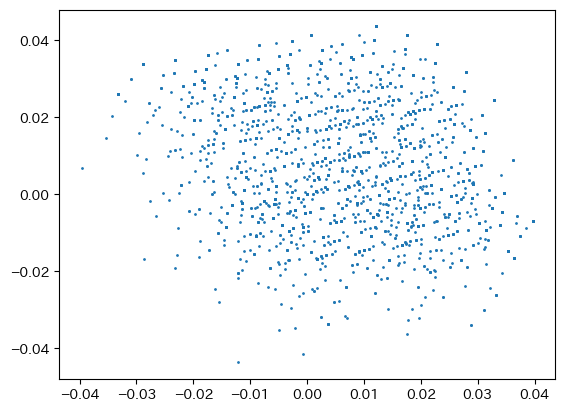

In [12]:
pca = PCA()
pca = pca.fit(matrix_keizai.T)
coords = pca.components_.T

plt.scatter(x=coords[:, 0], y=coords[:, 1], s=1)
plt.show()

In [21]:
import umap

# UMAPによる次元削減
reducer = umap.UMAP(
    n_neighbors=15, min_dist=1, n_components=2, random_state=42, n_jobs=1
)
embedding = reducer.fit_transform(matrix_keizai)

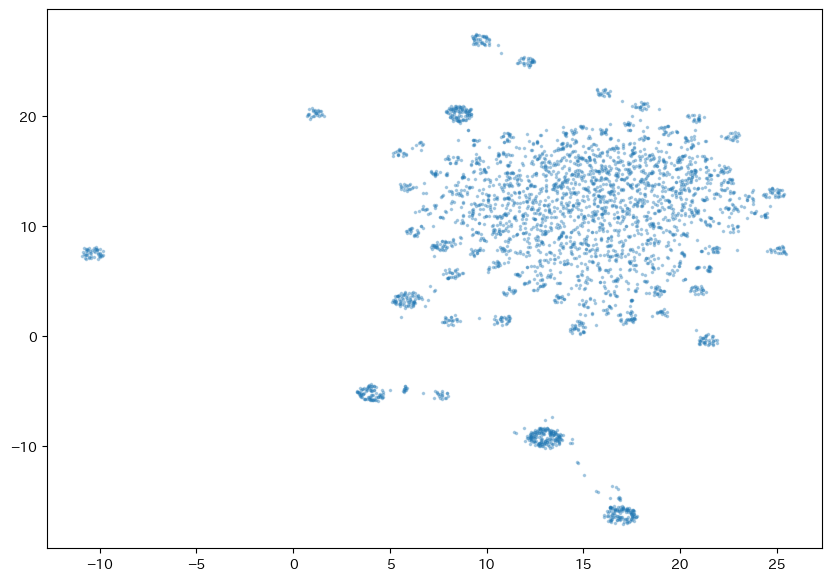

In [22]:
# UMAPの結果を含むDataFrameを作成し、matrixのインデックス（User_ID）を含める
umap_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
# umap_df["User_ID"] = matrix.index  # matrixのインデックスをUser_IDとする

plt.figure(figsize=(10, 7))
plt.scatter(
    umap_df["UMAP1"],
    umap_df["UMAP2"],
    marker=".",
    alpha=0.3,
    s=10,
)
plt.show()

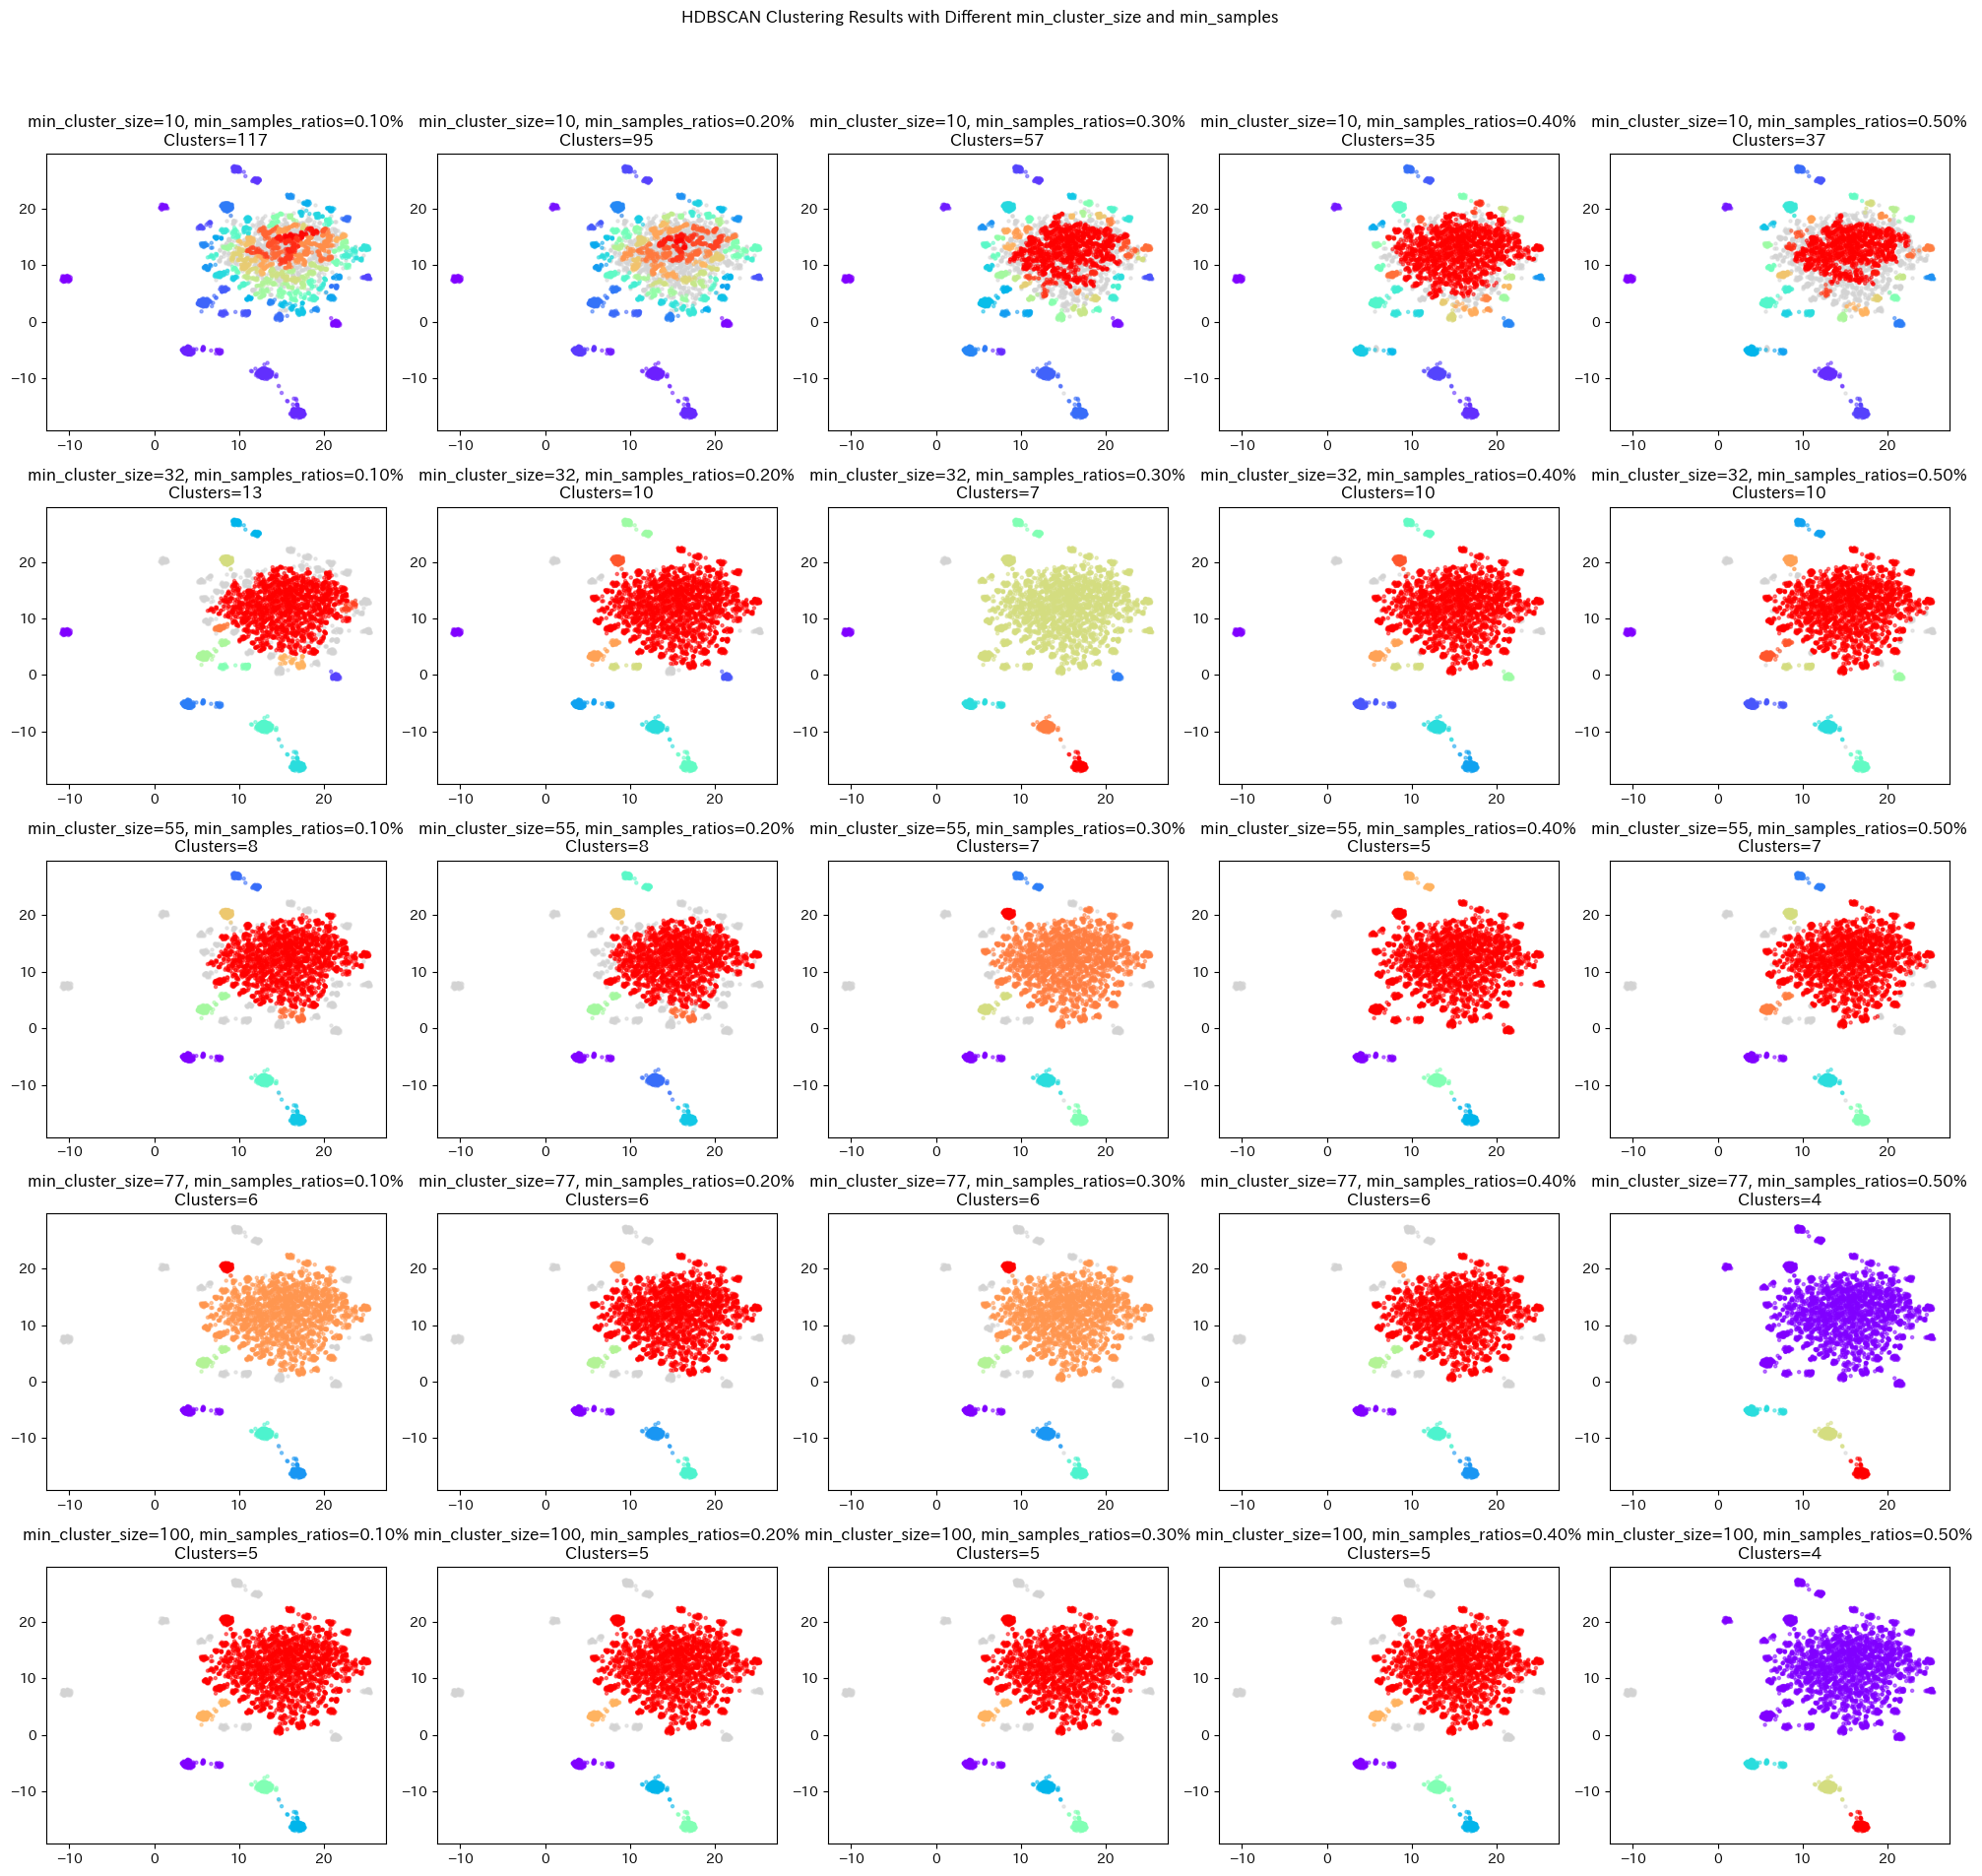

In [30]:
import hdbscan

# 例として使うmin_cluster_sizeとmin_samplesのパラメータリストを定義
min_cluster_sizes = np.linspace(10, 100, 5, dtype=int)  # クラスタの最小サイズ
min_samples_ratios = np.linspace(0.001, 0.005, 5)       # データの割合でmin_samplesを決定

# プロット数の決定
n_rows = len(min_cluster_sizes)
n_cols = len(min_samples_ratios)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * len(min_samples_ratios), 4 * len(min_cluster_sizes)))
fig.suptitle("HDBSCAN Clustering Results with Different min_cluster_size and min_samples")

tmp_df = matrix_keizai
# タイリング表示
for i, min_cluster_size in enumerate(min_cluster_sizes):
    for j, ratio in enumerate(min_samples_ratios):
        min_samples = int(len(tmp_df) * ratio)
        
        # HDBSCANのインスタンスを生成
        hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        labels = hdbscan_cluster.fit_predict(umap_df)
        
        # クラスタ数を取得（ノイズ点は除外するためsetから-1を除く）
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        # サブプロットにプロット
        ax = axes[i, j]
        # クラスタラベルが-1（ノイズ）のデータとクラスタのデータを分ける
        core_points = umap_df[labels != -1]
        core_labels = labels[labels != -1]
        noise_points = umap_df[labels == -1]

        # ノイズデータを薄い灰色でプロット
        ax.scatter(noise_points["UMAP1"], noise_points["UMAP2"], c="lightgray", s=5, marker="o", alpha=0.5, label="Noise")

        # クラスタデータをカラーマップでプロット
        scatter = ax.scatter(core_points["UMAP1"], core_points["UMAP2"], c=core_labels, s=5, marker="o", alpha=0.5, cmap="rainbow")

        ax.set_title(f"min_cluster_size={min_cluster_size}, min_samples_ratios={ratio * 100:.2f}%\nClusters={n_clusters}")

# タイリングをきれいに配置
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()